# Tải Dữ liệu

In [1]:
import kagglehub

# Download latest version
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")

print("Path to dataset files:", data_dir)

Path to dataset files: C:\Users\ADMIN\.cache\kagglehub\datasets\andrewmvd\dog-and-cat-detection\versions\1


# Import Các Thư Viện Cần Thiết

In [2]:

import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

# Set the random seed for reproducibility.
seed = 123
torch.manual_seed(seed)

# Định Nghĩa Class Dataset

In [3]:
# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_image_files.append(img_name)
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall('object'):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Image path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Annotation path
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)

        # Parse annotation
        label, bbox = self.parse_annotation(annotation_path)  # Get both label and bbox

        if self.transform:
            image = self.transform(image)

        return image, label, bbox

    def parse_annotation(self, annotation_path):
      tree = ET.parse(annotation_path)
      root = tree.getroot()

      # Get image size for normalization
      image_width = int(root.find('size/width').text)
      image_height = int(root.find('size/height').text)

      label = None
      bbox = None
      for obj in root.findall('object'):
          name = obj.find('name').text
          if label is None:  # Take the first label
              label = name
              # Get bounding box coordinates
              xmin = int(obj.find('bndbox/xmin').text)
              ymin = int(obj.find('bndbox/ymin').text)
              xmax = int(obj.find('bndbox/xmax').text)
              ymax = int(obj.find('bndbox/ymax').text)

              # Normalize bbox coordinates to [0, 1]
              bbox = [
                  xmin / image_width,
                  ymin / image_height,
                  xmax / image_width,
                  ymax / image_height,
              ]

      # Convert label to numerical representation (0 for cat, 1 for dog)
      label_num = 0 if label == 'cat' else 1 if label == 'dog' else -1

      return label_num, torch.tensor(bbox, dtype=torch.float32)

# Chuẩn Bị Dữ Liệu

In [4]:
# Data directory
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)
val_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)

# Filter datasets based on train_df and val_df
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df['image_name'].values]

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Xây Dựng Mô Hình

In [5]:
# Model with Two Heads
class TwoHeadedModel(nn.Module):
    def __init__(self, num_classes=2):
        super(TwoHeadedModel, self).__init__()
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.num_ftrs = self.base_model.fc.in_features

        # Remove the original fully connected layer
        self.base_model.fc = nn.Identity()

        # Classification head
        self.classifier = nn.Linear(self.num_ftrs, num_classes)

        # Bounding box regression head
        self.regressor = nn.Linear(self.num_ftrs, 4)

    def forward(self, x):
        x = self.base_model(x)
        class_logits = self.classifier(x)
        bbox_coords = torch.sigmoid(self.regressor(x))
        return class_logits, bbox_coords

In [6]:
# Model
model = TwoHeadedModel()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Vòng Lặp Huấn Luyện Mô Hình

In [7]:
# Training Loop
num_epochs = 10
for epoch in tqdm.tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    for batch_idx, (data, targets, bboxes) in enumerate(tqdm.tqdm(train_loader, desc="Training", leave=False)):
        data = data.to(device)
        targets = targets.to(device)
        bboxes = bboxes.to(device)

        scores, pred_bboxes = model(data)
        loss_class = criterion_class(scores, targets)
        loss_bbox = criterion_bbox(pred_bboxes, bboxes)
        loss = loss_class + loss_bbox  # Combine losses

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss_bbox = 0
        total_samples = 0
        for data, targets, bboxes in tqdm.tqdm(val_loader, desc="Validation", leave=False):
            data = data.to(device)
            targets = targets.to(device)
            bboxes = bboxes.to(device)

            scores, pred_bboxes = model(data)
            _, predictions = scores.max(1)
            correct += (predictions == targets).sum()
            total += targets.size(0)

            # Calculate bbox loss for monitoring (optional)
            total_loss_bbox += criterion_bbox(pred_bboxes, bboxes).item() * data.size(0)
            total_samples += data.size(0)

        avg_loss_bbox = total_loss_bbox / total_samples

        print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {float(correct)/float(total)*100:.2f}%, '
              f'Avg. Bbox Loss: {avg_loss_bbox:.4f}')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1/10, Validation Accuracy: 91.06%, Avg. Bbox Loss: 0.0179


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/10, Validation Accuracy: 95.39%, Avg. Bbox Loss: 0.0128


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/10, Validation Accuracy: 94.31%, Avg. Bbox Loss: 0.0103


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/10, Validation Accuracy: 90.24%, Avg. Bbox Loss: 0.0090


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/10, Validation Accuracy: 86.59%, Avg. Bbox Loss: 0.0102


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6/10, Validation Accuracy: 91.87%, Avg. Bbox Loss: 0.0111


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7/10, Validation Accuracy: 95.26%, Avg. Bbox Loss: 0.0110


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8/10, Validation Accuracy: 93.50%, Avg. Bbox Loss: 0.0091


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9/10, Validation Accuracy: 94.44%, Avg. Bbox Loss: 0.0089


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10/10, Validation Accuracy: 92.41%, Avg. Bbox Loss: 0.0107


# Biểu diễn dự đoán model

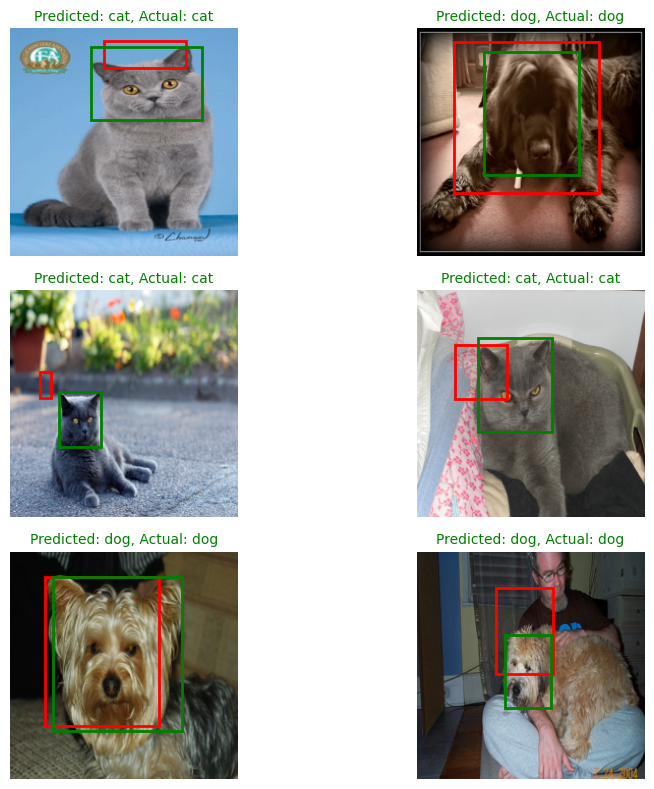

In [9]:
# Function to visualize predictions with bounding boxes
def visualize_predictions_with_bbox(model, dataloader, num_images=6):
    model.eval()
    images_so_far = 0
    class_names = ["cat", "dog"]
    fig = plt.figure(figsize=(10, 8))

    with torch.no_grad():
        for i, (images, labels, bboxes) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            class_outputs, bbox_outputs = model(images)
            _, preds = torch.max(class_outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')

                # Denormalize and display the image
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
                img = std * img + mean
                img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
                ax.imshow(img)

                # Get predicted bounding box coordinates
                pred_bbox = bbox_outputs[j].cpu().numpy()
                x_min, y_min, x_max, y_max = pred_bbox

                # Scale bounding box coordinates back to image size
                x_min = int(x_min * img.shape[1])
                y_min = int(y_min * img.shape[0])
                x_max = int(x_max * img.shape[1])
                y_max = int(y_max * img.shape[0])

                # Draw the bounding box on the image
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

                # Get ground truth bounding box coordinates
                gt_bbox = bboxes[j].cpu().numpy()
                gt_x_min, gt_y_min, gt_x_max, gt_y_max = gt_bbox

                # Scale ground truth bounding box coordinates back to image size
                gt_x_min = int(gt_x_min * img.shape[1])
                gt_y_min = int(gt_y_min * img.shape[0])
                gt_x_max = int(gt_x_max * img.shape[1])
                gt_y_max = int(gt_y_max * img.shape[0])

                # Draw the ground truth bounding box on the image
                gt_rect = patches.Rectangle((gt_x_min, gt_y_min), gt_x_max - gt_x_min, gt_y_max - gt_y_min, linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(gt_rect)

                ax.set_title(
                    f"Predicted: {class_names[preds[j]]}, Actual: {class_names[labels[j]]}",
                    fontdict={
                        "fontsize": 10,
                        "color": "green" if preds[j] == labels[j] else "red",
                    },
                )

                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return

# Visualize some predictions
visualize_predictions_with_bbox(model, val_loader)